# Going Deeper_04. 이미지 어디까지 우려볼까?

## 프로젝트: CutMix 또는 Mixup 비교실험 하기

## 0. 데이터 불러오기

In [1]:
## 주요 라이브러리 버전 확인

import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [2]:
## TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

print('=3')

=3


In [3]:
## GPU 환경 확인하기!
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
## tfds에는 다양한 데이터들이 있음
## GD2에는 cats_vs_dogs뭐 이런거를 불러와서 사용
## 여기서는 standford_dogs라는 데이터를 불러와서 사용한다.

## if validation 까지 3개로 나누고 싶다면??
## (ds_train, ds_validation, ds_test)
## 저렇게 해주고
## 밑에 split에     split=['train','validation[50%]' 'test[50%]'], 이렇게 해주면 된다.

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    ## 데이터를 train이랑 test로 나눠달라는거
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('=3')

=3


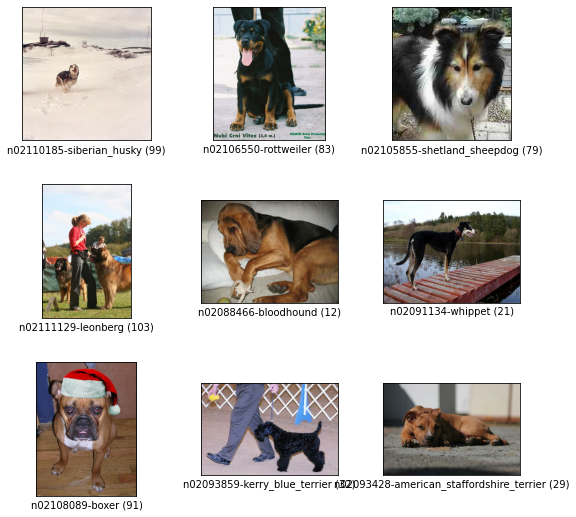

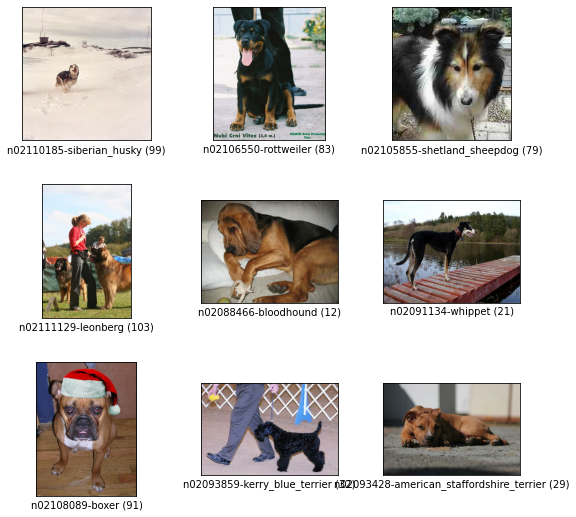

In [5]:
## 다운로드한 데이터 확인

tfds.show_examples(ds_train, ds_info)

## 1. Augmentation을 적용한 데이터셋 만들기

In [6]:
## 이미지 크기를 바꿔주는 코드
## 이미지는 픽셀임 그래서 픽셀로 이루어진 집합이다.
## 이미지를 0-1 사이의 float32로 normalize해주고 (224, 224) 사이즈로 resize 해준다.

def normalize_and_resize_img(image, label):
    ## Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

print('=3')

=3


normalize_and_resize_img 이거는 train 과 test에 사용되는 모~든 이미지에 적용된다.

In [7]:
## augment를 했을 때 좋아질 수도 있지만 
## 나빠질 수도 있다.~

def augment(image,label):
    ## 좌우로 대칭을 해줄지?
    image = tf.image.random_flip_left_right(image)
    ## 밝게 해줄지 말지?
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

print('=3')

=3


In [8]:
## 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  ## 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       ## augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


In [9]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

94781440/94765736 [==============================] - 0s 0us/step
=3


In [10]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [11]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('=3')

=3


### (1) Augmentation 기법: Cutmix Augmentation

#### 1) 이미지 섞기

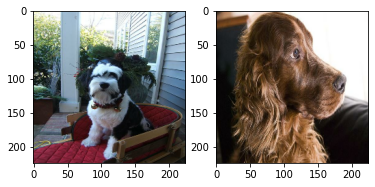

In [12]:
import matplotlib.pyplot as plt

## 데이터셋에서 이미지 2개를 가져온다.
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [13]:
def get_clip_box(image_a, image_b):
    ## image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    ## get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    ## get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    ## clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x: ', x_min, x_max)
print('y: ', y_min, y_max)

x:  tf.Tensor(8, shape=(), dtype=int32) tf.Tensor(100, shape=(), dtype=int32)
y:  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(94, shape=(), dtype=int32)


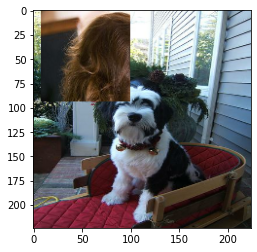

In [14]:
## mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

#### 2) 라벨 섞기

In [15]:
## mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.8276467 ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.17235331, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [16]:
## mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


### (2) Augmentation 기법: Mixup Augmentation

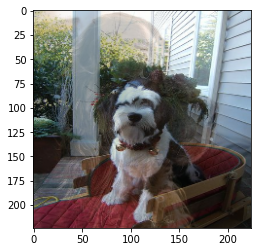

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.7352555  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.26474452 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [17]:
num_classes = ds_info.features['label'].num_classes

## function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [18]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


In [19]:
def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [20]:
## CutMix를 적용할 수 있도록 변경한 apply_normalize_on_dataset() 함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


In [21]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)
print('슝💨')

슝💨


## 2. 모델 만들기

In [22]:
no_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [23]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')


=3


In [24]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


In [25]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(224,224,3),
    pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])
print('=3')

=3


## 3. 모델 훈련하기

In [26]:
## Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

no_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


In [27]:
history_no_aug_resnet50 = no_aug_resnet50.fit(
    ds_train_no_aug, ## augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 199s 205ms/step - loss: 2.1865 - accuracy: 0.4487 - val_loss: 3.4249 - val_accuracy: 0.2016
Epoch 2/20
750/750 [==============================] - 154s 206ms/step - loss: 0.7061 - accuracy: 0.8059 - val_loss: 1.0770 - val_accuracy: 0.6821
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 0.2124 - accuracy: 0.9570 - val_loss: 0.9779 - val_accuracy: 0.7126
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0661 - accuracy: 0.9928 - val_loss: 0.9266 - val_accuracy: 0.7299
Epoch 5/20
750/750 [==============================] - 154s 206ms/step - loss: 0.0610 - accuracy: 0.9958 - val_loss: 0.9349 - val_accuracy: 0.7401
Epoch 6/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0214 - accuracy: 0.9988 - val_loss: 0.9289 - val_accuracy: 0.7427
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0117 - accuracy: 0.9995 - val_loss: 0.9373 -

In [28]:
history_aug_resnet50 = aug_resnet50.fit(
    ds_train_aug, ## augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 161s 206ms/step - loss: 2.2986 - accuracy: 0.4218 - val_loss: 2.9960 - val_accuracy: 0.2615
Epoch 2/20
750/750 [==============================] - 154s 205ms/step - loss: 0.9406 - accuracy: 0.7328 - val_loss: 1.2984 - val_accuracy: 0.6274
Epoch 3/20
750/750 [==============================] - 154s 205ms/step - loss: 0.5095 - accuracy: 0.8635 - val_loss: 1.0655 - val_accuracy: 0.6925
Epoch 4/20
750/750 [==============================] - 154s 205ms/step - loss: 0.2618 - accuracy: 0.9423 - val_loss: 1.1325 - val_accuracy: 0.6776
Epoch 5/20
750/750 [==============================] - 154s 205ms/step - loss: 0.1412 - accuracy: 0.9726 - val_loss: 0.9799 - val_accuracy: 0.7218
Epoch 6/20
750/750 [==============================] - 153s 205ms/step - loss: 0.0788 - accuracy: 0.9892 - val_loss: 0.9878 - val_accuracy: 0.7248
Epoch 7/20
750/750 [==============================] - 154s 205ms/step - loss: 0.0612 - accuracy: 0.9914 - val_loss: 1.0212 -

In [29]:
history_cutmix_resnet50 = cutmix_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 163s 208ms/step - loss: 3.8375 - accuracy: 0.2055 - val_loss: 4.1039 - val_accuracy: 0.1198
Epoch 2/20
750/750 [==============================] - 155s 206ms/step - loss: 2.9377 - accuracy: 0.4347 - val_loss: 1.5060 - val_accuracy: 0.5757
Epoch 3/20
750/750 [==============================] - 155s 206ms/step - loss: 2.6102 - accuracy: 0.5369 - val_loss: 1.2517 - val_accuracy: 0.6610
Epoch 4/20
750/750 [==============================] - 155s 207ms/step - loss: 2.4269 - accuracy: 0.5977 - val_loss: 1.2847 - val_accuracy: 0.6480
Epoch 5/20
750/750 [==============================] - 155s 206ms/step - loss: 2.2564 - accuracy: 0.6522 - val_loss: 1.3329 - val_accuracy: 0.6510
Epoch 6/20
750/750 [==============================] - 155s 207ms/step - loss: 2.1449 - accuracy: 0.6897 - val_loss: 1.1952 - val_accuracy: 0.6842
Epoch 7/20
750/750 [==============================] - 155s 206ms/step - loss: 2.0485 - accuracy: 0.7157 - val_loss: 1.2069 -

In [30]:
history_mixup_resnet50 = mixup_resnet50.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/20
750/750 [==============================] - 162s 208ms/step - loss: 3.7432 - accuracy: 0.2338 - val_loss: 4.6661 - val_accuracy: 0.0633
Epoch 2/20
750/750 [==============================] - 155s 207ms/step - loss: 2.8828 - accuracy: 0.4768 - val_loss: 1.6176 - val_accuracy: 0.5624
Epoch 3/20
750/750 [==============================] - 155s 207ms/step - loss: 2.6020 - accuracy: 0.5688 - val_loss: 1.3631 - val_accuracy: 0.6184
Epoch 4/20
750/750 [==============================] - 155s 206ms/step - loss: 2.3962 - accuracy: 0.6492 - val_loss: 1.4413 - val_accuracy: 0.6083
Epoch 5/20
750/750 [==============================] - 155s 206ms/step - loss: 2.2471 - accuracy: 0.7153 - val_loss: 1.2131 - val_accuracy: 0.6673
Epoch 6/20
750/750 [==============================] - 155s 207ms/step - loss: 2.1557 - accuracy: 0.7462 - val_loss: 1.2426 - val_accuracy: 0.6667
Epoch 7/20
750/750 [==============================] - 155s 207ms/step - loss: 2.0811 - accuracy: 0.7713 - val_loss: 1.1834 -

## 4. 훈련 과정 시각화하기

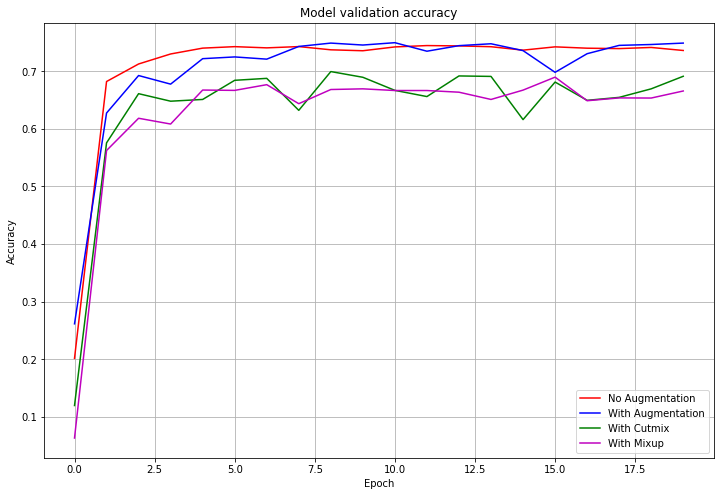

In [31]:
plt.figure(figsize=(12,8))
plt.plot(history_no_aug_resnet50.history['val_accuracy'], 'r')
plt.plot(history_aug_resnet50.history['val_accuracy'], 'b')
plt.plot(history_cutmix_resnet50 .history['val_accuracy'], 'g')
plt.plot(history_mixup_resnet50.history['val_accuracy'], 'm')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='lower right')
plt.grid(True)
plt.show()

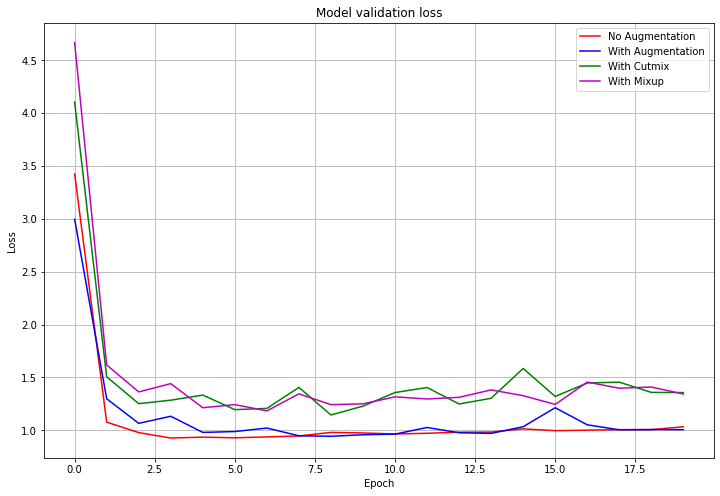

In [32]:
plt.figure(figsize=(12,8))
plt.plot(history_no_aug_resnet50.history['val_loss'], 'r')
plt.plot(history_aug_resnet50.history['val_loss'], 'b')
plt.plot(history_cutmix_resnet50 .history['val_loss'], 'g')
plt.plot(history_mixup_resnet50.history['val_loss'], 'm')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With Cutmix', 'With Mixup'], loc='upper right')
plt.grid(True)
plt.show()

## 5. Augmentation에 의한 모델 성능 비교

In [33]:
import pandas as pd

accuracy_data = {'No Augmentation': history_no_aug_resnet50.history['val_accuracy'],
                 'With Augmentation': history_aug_resnet50.history['val_accuracy'],
                 'With CutMix': history_cutmix_resnet50 .history['val_accuracy'],
                 'With MixUp': history_mixup_resnet50.history['val_accuracy']   
}

accuracy_df = pd.DataFrame(accuracy_data)
accuracy_df[-5:]

,No Augmentation,With Augmentation,With CutMix,With MixUp
15,0.742304,0.698111,0.681203,0.689716
16,0.739972,0.730410,0.649487,0.648787
17,0.739272,0.744869,0.654618,0.653685
18,0.741255,0.746385,0.669426,0.653452
19,0.736007,0.748834,0.691231,0.665695


In [34]:
accuracy_df.describe()

,No Augmentation,With Augmentation,With CutMix,With MixUp
count,20.000000,20.000000,20.000000,20.000000
mean,0.708681,0.702233,0.635792,0.623531
std,0.120213,0.108205,0.125164,0.134853
min,0.201609,0.261544,0.119753,0.063316
25%,0.735891,0.715252,0.649108,0.647505
50%,0.740030,0.735250,0.663888,0.664646
75%,0.742362,0.745686,0.688083,0.667240
max,0.744520,0.749534,0.699394,0.689716


# 회고!

## < 어려웠던 점>    
3번노드를 제대로 보지 않아서 그런가 코드를 구현하는 것도 힘들었다. 그리고 사실 4가지를 비교해봤지만 한 눈에 결과값을 알아보는 과정도 어려웠던 것 같다. 코드에 대한 이해도가 부족해서 그런 것 같다. 그리고 cutmix, mixup을 해봤는데 사실 왜하는지 잘 모르겠다. 귀여운 강아지가 섞이니까 이상해져서 눈으로 봤을 때는 아직까지 왜 하는지 잘 모르겠다.. 이건 바로 노드 3을 공부를 제대로 안해서 그런 것 같다. 그리고 열심히 공부했던 부분도 코드로 구현하니까 이해가 되지 않아서 일단 복사붙여넣기가 아니라 손으로 직접 쳤다.. 적고 보니까 다 어려웠던 것 같다.. 

## < 알아낸 점> & < 아직까지 모호한 점>   
- CutMix는 이름 그대로 이미지 데이터를 자르고 섞는 기법이다.  
- CMixup은 특정 비율로 픽셀별 값을 섞는 방식, Cutout은 이미지를 자르는 방식이다. CutMix는 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법이다.     

- Mixup은 앞에서 보여드린 CutMix보다 간단하게 이미지와 라벨을 섞어준다. 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어주면 된다.

## <시도한 것들>  
4가지를 비교해봤는데 일단 잘 모르지만 결과값을 비교해보자!!       

- 일단 Augmentation vs. No Augmentation 을 비교    
    -  accuracy는 No Augmentation이 18번째 epoch에서! 0.736007,  Augmentation이 마지막 apoch에서 0.748834로 가장 높은 성능을 보여준다. 근데 결론적으로 봐서는 Augmentation 이 더 높은 성능을 보여준다.    
    
- 그리고 CutMix 랑 Mixup 을 비교   
    - CutMix 일 때가 0.691231 로 마지막에서 가장 높았고, MixUp 은 0.689716 가 제일 높은 accuracy 였다. 그래서 Mixup 이 조금 더 좋은 성능을 보였던 것 같다. 두 개의 이미지를 가지고 픽셀별로 값을 비율에 맞춰서 섞어주는 방식이 더 안정적인 것 같다.
    - ( 사실 눈으로 봐도 Mixup이 나은듯.....ㅎㅎㅎ)    

- 최종 비교   
    - 사실 심화 기법이라고 해서 CutMix랑 Mixup 을 사용해봤는데 결론을 봤을 때에는 Augmentation일 때가 제일 높았고 좋은 성능을 보여줬다. 

## < 자기 다짐>   
이번에 진짜 신기한 기법을 알게 되었고 한 번 해봐서 재밌었다. 그리고 결과를 비교했는데 사실 왜 한지 잘 모르겠지만 새로운 것을 알게된 점을 좋았던 것 같다. 이론을 보고 코드를 봐도 이해가 별게로 되기는 했지만 ! 그냥 코드가 아 ~ 이런말이구나 라는 건 알 수 있어서 프로젝트 노드를 하기 전에는 꼭 Lecture노드를 열심히 봐야겠다고 생각했다. 특히 ! 이제는 CV 를 같이하는 사람들이랑 함께 모여서 노드를 보니까 더 꼼꼼하게 보려고 노력하고 미루지 않아야겠다고 생각했다. 항상 다짐은 하는데 프로젝트를 하고나서 꼭 다짐을 하는 것 같네.....하지만 이제는 진짜 열심히 해보자! 화이팅!!!